# Transfer Learning with ImageNet

### What is Transfer Learning?

Transfer learning is an approach in machine learning that leverages knowledge acquired by a model trained on one task to improve performance on another related task.

Instead of training a model from the start for a specific task (like image classification), a **pre-trained model** on a similar task is used as a starting point.

The idea in Transfer Learning is that models trained, general tasks such as image classification on ImageNet, develop internal representations that capture generalizable and useful features.

### What is a Pre-Trained model?

A pre-trained model is a saved network that was previously trained on a large dataset, typically on image classification tasks.

We use the pre-trained model in transfer learning to customize our created model to a given task.

In [1]:
# Utils to run notebook on Kaggle

%matplotlib inline
import os
import cv2
import glob
import pickle
import matplotlib
import numpy as np
import pandas as pd
import imageio as im
import seaborn as sns
import tensorflow as tf
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow import keras
from keras import models
from pickle import dump
from pickle import load
from tensorflow import keras
from tensorflow.keras.utils import to_categorical, plot_model, img_to_array, load_img, array_to_img
from tensorflow.keras import regularizers, layers
from tensorflow.keras.applications import InceptionV3, VGG16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D,MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
#from keras.preprocessing import image
import keras.utils as image

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# load and save files with pickle
def save_pickle(file, file_name):
    dump(file, open(file_name, 'wb'))
    print('Saved: %s' % file_name)

def load_pickle(file_name):
    return load(open(file_name, 'rb'))

In [3]:
# Defining accuracy and loss plot funtion
def plot_loss_accuracy(hist, save_image_filename, len_epochs):
    epochs = len_epochs
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']

    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, 'r--', label='Training Accuracy')
    plt.plot(epochs_range, val_acc,'b-' , label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, 'r--', label='Training Loss')
    plt.plot(epochs_range, val_loss, 'b-', label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.savefig(save_image_filename) 
plt.show()

In [4]:
def show_image(path):
    imagen = Image.open(path)
    plt.imshow(imagen)
    plt.axis('off')
    plt.show()

In [5]:
# PATHS
dspath = '/kaggle/input/intel-image-classification'
# path to the folder containing the subfolders with the training images
trainpath = f'{dspath}/seg_train/seg_train'
# path to the folder containing the subfolders with the testing images
testpath = f'{dspath}/seg_test/seg_test'
predpath = f'{dspath}/seg_pred/seg_pred'

# path to the folder containing the models in our experiments
models_path = '/kaggle/input/assignment-05-experiments'
# path to the folder containg data of our expriments
best_model = load_pickle(f'{models_path}/pickle_model_epoch120.pkl')
best_model_plt = f'{models_path}/plot_120.png'

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-05-16 06:12:30        10563
variables.h5                                   2023-05-16 06:12:30      6538368
metadata.json                                  2023-05-16 06:12:30           64
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......activation_4
.........vars
......activation_5
.........vars
......batch_normalization
.........vars
............0
............1
............2
............3
......batch_normalization_1
.........vars
............0
............1
............2
............3
......batch_normalization_2
.........vars
............0
............1
............2
............3
......batch_normalization_3
.........vars
............0
............1
............2
...

In [6]:
# Create a dictionary to change text labels into int numerical labels (Ordered alphabetically)
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
class_labels = {class_name:i for i, class_name in enumerate(class_names)}

print(class_labels)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


In [7]:
# Resize of images
IMAGE_SIZE = (150, 150)

# def for labeling 
def labeling(folder_path, images, labels):
    # loop through all subfolders in the folder_path
    for label in os.listdir(folder_path):
        # get the path to the subfolder
        label_path = os.path.join(folder_path, label)

        # convert label text to label number
        label_number = class_labels[label]

        # loop through all images in subfolder
        for file_name in os.listdir(label_path):
            # upload image using Pillow
            image = Image.open(os.path.join(label_path, file_name))

            # resize image to desired size
            image = image.resize(IMAGE_SIZE)

            # convert the image to a Numpy array  
            image = np.array(image)

            # add image to testing_image list
            images.append(image)

            # add image label to testing_label list
            labels.append(label_number)
    # convert the images and labels list to numpy array
    images = np.array(images, dtype='float32')
    labels = np.array(labels, dtype='int32')
    
    return images, labels

In [8]:
# Training labeling
# list to store the images and their labels
training_images = []
training_labels = []
x_train, y_train = labeling(trainpath, training_images, training_labels)

# Testing labeling
# list to store the images and their labels
testing_images = []
testing_labels = []
x_test, y_test = labeling(testpath, testing_images, testing_labels)

In [9]:
# Find the unique numbers from the train labels
num_clases = len(np.unique(y_train))

# Change the labels from categorical to one-hot encoding
y_train = to_categorical(y_train, num_clases)
y_test = to_categorical(y_test, num_clases)

# Visualize y_train after one hot encoding
print(y_train[0])

# Using Z-score normalization to converge faster and improve accuracy
mean = np.mean(x_train)
std = np.std(x_train)

x_train = (x_train - mean) / (std+1e-7)
x_test = (x_test - mean) / (std+1e-7)

[0. 0. 0. 1. 0. 0.]


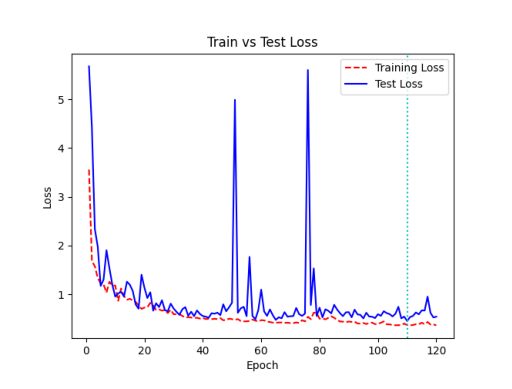

In [10]:
show_image(best_model_plt)

1/1 [==============================] - 7s 7s/step
Predicted class is: forest


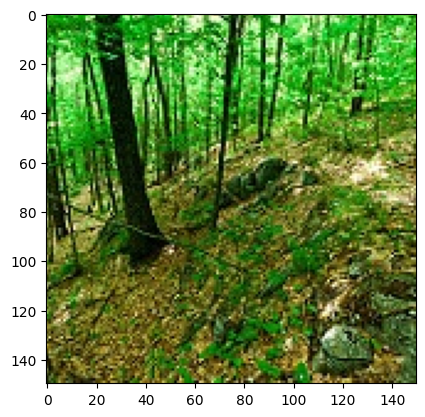

In [11]:
# predicting images
img = load_img(f'{dspath}/seg_pred/seg_pred/10209.jpg')
plt.imshow(img)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])
predict_x = best_model.predict(images)[0]
classes_x = np.argmax(predict_x)

print("Predicted class is:", class_names[classes_x])

1/1 [==============================] - 0s 28ms/step
Predicted class is: forest


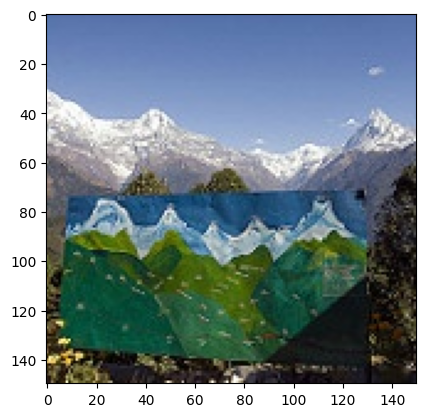

In [12]:
img = load_img(f'{dspath}/seg_test/seg_test/mountain/20071.jpg')
plt.imshow(img)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])
predict_x = best_model.predict(images)[0]
classes_x = np.argmax(predict_x)

print("Predicted class is:", class_names[classes_x])

# Using Pre-Trained Model

In [13]:
IMAGE_SIZE = (150, 150)
IMAGE_SHAPE = (150, 150, 3)
EPOCHS = 10
BATCH_SIZE = 128

### Creating train and test datasets from TensorFlow
To create image datasets use using tf, we use **image_dataset_from_directory** function.

It generates a Dataset that yields batches of images from the subdirectories like the class names: sea, forest, glacier, street, buildings, mountains.

In [14]:
train_ds = image_dataset_from_directory(
  trainpath,
  seed = 123,
  image_size = IMAGE_SIZE,
  batch_size = BATCH_SIZE,
  label_mode = 'categorical')
val_ds = image_dataset_from_directory(
  testpath,
  seed = 123,
  image_size = IMAGE_SIZE,
  batch_size = BATCH_SIZE,
  label_mode = 'categorical')

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


In [15]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=IMAGE_SHAPE)

for layer in base_model.layers:
    layer.trainable = False
    
model_trasfer = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=IMAGE_SHAPE),
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(6, activation='softmax')])

model_trasfer.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

87910968/87910968 [==============================] - 0s 0us/step


In [16]:
history_image_net = model_trasfer.fit(train_ds,
                                      validation_data = val_ds,
                                      steps_per_epoch = EPOCHS,
                                      epochs = EPOCHS)

Epoch 1/10
10/10 [==============================] - 17s 870ms/step - loss: 0.8787 - accuracy: 0.7555 - val_loss: 1.5555 - val_accuracy: 0.8063
Epoch 2/10
10/10 [==============================] - 5s 583ms/step - loss: 0.5140 - accuracy: 0.8383 - val_loss: 1.0557 - val_accuracy: 0.8403
Epoch 3/10
10/10 [==============================] - 5s 504ms/step - loss: 0.5135 - accuracy: 0.8234 - val_loss: 0.6279 - val_accuracy: 0.8693
Epoch 4/10
10/10 [==============================] - 5s 521ms/step - loss: 0.4597 - accuracy: 0.8516 - val_loss: 0.5985 - val_accuracy: 0.8630
Epoch 5/10
10/10 [==============================] - 5s 510ms/step - loss: 0.3474 - accuracy: 0.8867 - val_loss: 0.4922 - val_accuracy: 0.8700
Epoch 6/10
10/10 [==============================] - 5s 514ms/step - loss: 0.3993 - accuracy: 0.8570 - val_loss: 0.5504 - val_accuracy: 0.8480
Epoch 7/10
10/10 [==============================] - 5s 498ms/step - loss: 0.4198 - accuracy: 0.8523 - val_loss: 0.3455 - val_accuracy: 0.8897
Epoch

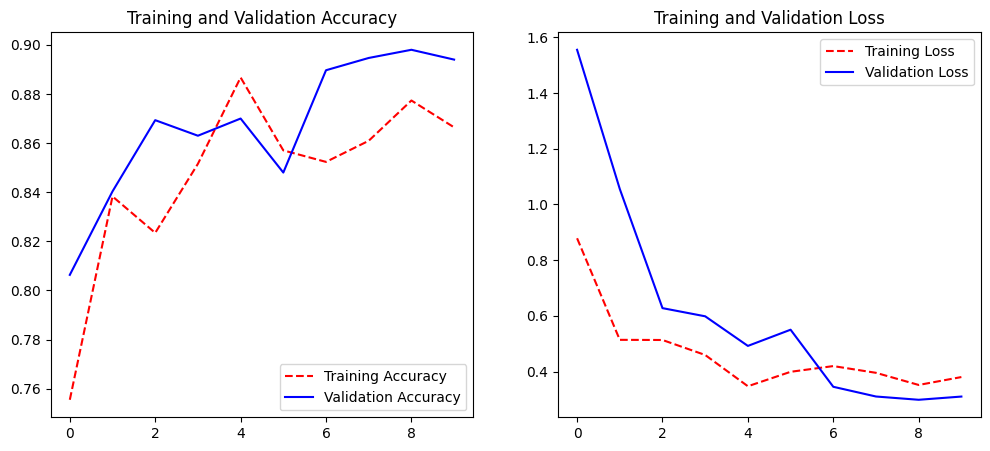

In [17]:
plot_loss_accuracy(history_image_net, 'ImageNet accuracy.png', EPOCHS)

In [18]:
## Data augmentation
datagen = ImageDataGenerator(rotation_range = 15,
                             width_shift_range = 0.1,
                             height_shift_range = 0.1,
                             horizontal_flip = True,
                             vertical_flip = True)

checkpoint_model_name = 'transfer_learning_model.hdf5'
checkpoint = ModelCheckpoint(checkpoint_model_name,
                             verbose = 1,
                             save_best_only = True,
                             monitor = 'val_accuracy')

In [21]:
history_model_transfer_learning = best_model.fit(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
          callbacks=[checkpoint],
          steps_per_epoch=x_train.shape[0] // BATCH_SIZE, 
          epochs=EPOCHS,
          verbose=1,
          validation_data=(x_test, y_test))

Epoch 1/10


2023-05-20 18:15:21.444652: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


109/109 [==============================] - ETA: 0s - loss: 1.2322 - accuracy: 0.7218
Epoch 1: val_accuracy improved from -inf to 0.71100, saving model to transfer_learning_model.hdf5
109/109 [==============================] - 102s 841ms/step - loss: 1.2322 - accuracy: 0.7218 - val_loss: 1.3726 - val_accuracy: 0.7110
Epoch 2/10
109/109 [==============================] - ETA: 0s - loss: 0.7112 - accuracy: 0.8055
Epoch 2: val_accuracy did not improve from 0.71100
109/109 [==============================] - 86s 784ms/step - loss: 0.7112 - accuracy: 0.8055 - val_loss: 2.2736 - val_accuracy: 0.5790
Epoch 3/10
109/109 [==============================] - ETA: 0s - loss: 0.6462 - accuracy: 0.8346
Epoch 3: val_accuracy improved from 0.71100 to 0.78033, saving model to transfer_learning_model.hdf5
109/109 [==============================] - 87s 795ms/step - loss: 0.6462 - accuracy: 0.8346 - val_loss: 0.7335 - val_accuracy: 0.7803
Epoch 4/10
109/109 [==============================] - ETA: 0s - loss: 

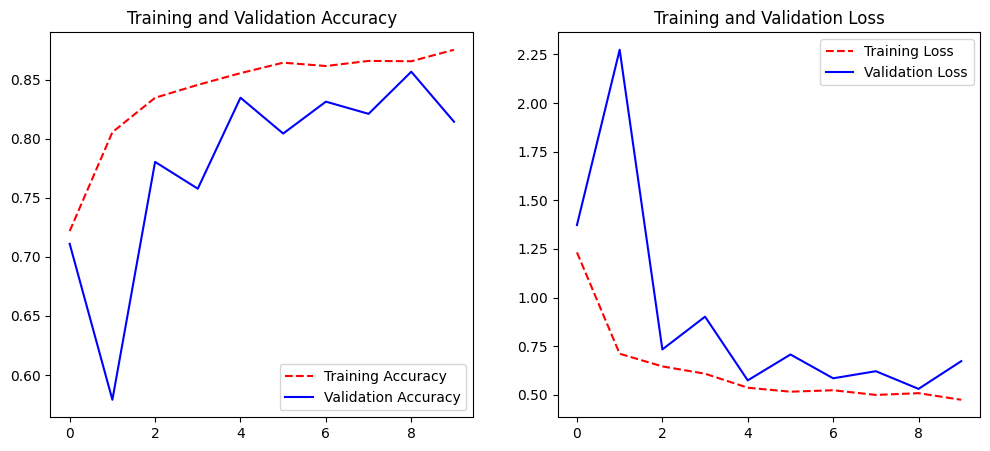

In [23]:
plot_loss_accuracy(history_model_transfer_learning, 'Our model accuracy.png', EPOCHS)

In [26]:
history_image_net_labels = model_trasfer.fit(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
                                             callbacks=[checkpoint],
                                             steps_per_epoch = x_train.shape[0] // BATCH_SIZE,
                                             epochs = EPOCHS,
                                             validation_data = (x_test, y_test))

Epoch 1/10
109/109 [==============================] - ETA: 0s - loss: 1.2236 - accuracy: 0.5510
Epoch 1: val_accuracy did not improve from 0.85667
109/109 [==============================] - 80s 709ms/step - loss: 1.2236 - accuracy: 0.5510 - val_loss: 1.2912 - val_accuracy: 0.5040
Epoch 2/10
109/109 [==============================] - ETA: 0s - loss: 0.9685 - accuracy: 0.6227
Epoch 2: val_accuracy did not improve from 0.85667
109/109 [==============================] - 78s 714ms/step - loss: 0.9685 - accuracy: 0.6227 - val_loss: 1.1118 - val_accuracy: 0.6180
Epoch 3/10
109/109 [==============================] - ETA: 0s - loss: 0.9133 - accuracy: 0.6440
Epoch 3: val_accuracy did not improve from 0.85667
109/109 [==============================] - 75s 691ms/step - loss: 0.9133 - accuracy: 0.6440 - val_loss: 0.9698 - val_accuracy: 0.6590
Epoch 4/10
109/109 [==============================] - ETA: 0s - loss: 0.8893 - accuracy: 0.6544
Epoch 4: val_accuracy did not improve from 0.85667
109/109 [=

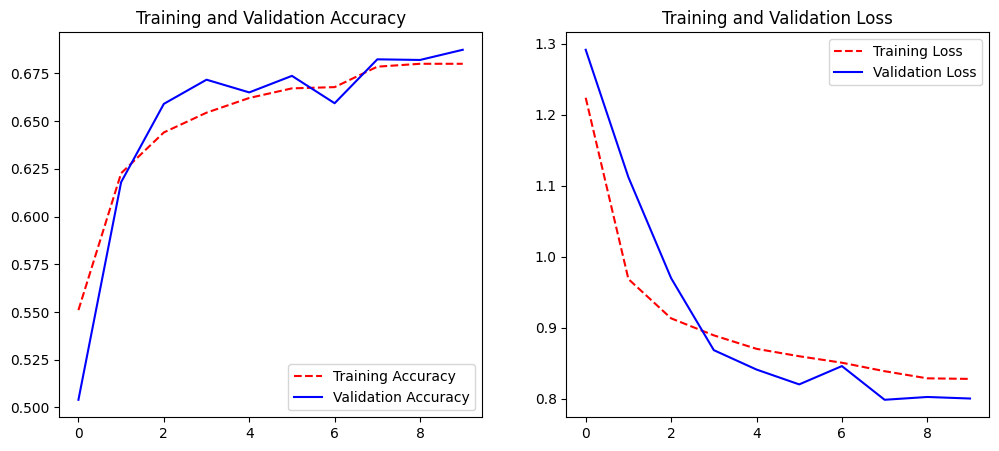

In [27]:
plot_loss_accuracy(history_image_net_labels, 'Transfer Learning with Model accuracy.png', EPOCHS)

1/1 [==============================] - 0s 39ms/step
Predicted class is: glacier


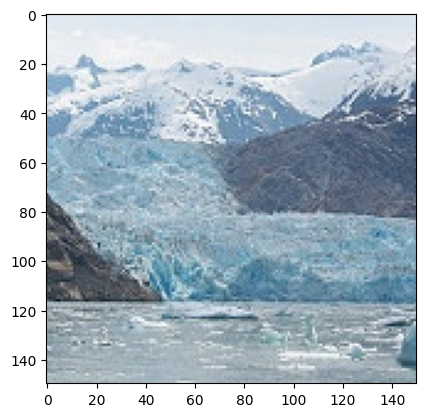

In [42]:
img = load_img(f'{dspath}/seg_pred/seg_pred/101.jpg')
plt.imshow(img)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])
predict_x = model_trasfer.predict(images)[0]
classes_x = np.argmax(predict_x)

print("Predicted class is:", class_names[classes_x])

1/1 [==============================] - 0s 33ms/step
Predicted class is: buildings


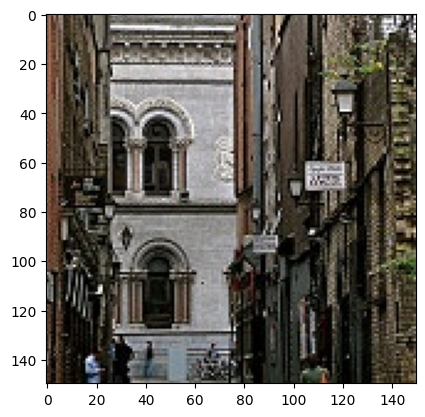

In [43]:
img = load_img(f'{dspath}/seg_pred/seg_pred/10073.jpg')
plt.imshow(img)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])
predict_x = model_trasfer.predict(images)[0]
classes_x = np.argmax(predict_x)

print("Predicted class is:", class_names[classes_x])

1/1 [==============================] - 0s 32ms/step
Predicted class is: street


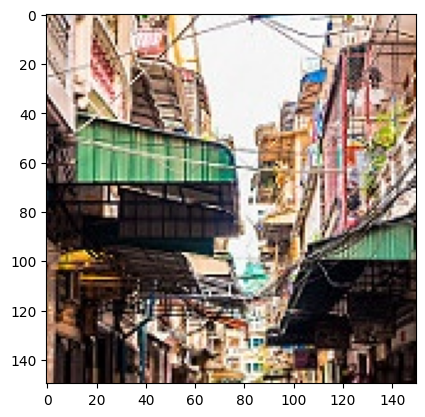

In [44]:
img = load_img(f'{dspath}/seg_pred/seg_pred/10082.jpg')
plt.imshow(img)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])
predict_x = model_trasfer.predict(images)[0]
classes_x = np.argmax(predict_x)

print("Predicted class is:", class_names[classes_x])